In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn 
import scipy as spa
import h5py


## Connecting to the GPU

In [29]:
# 1. learn how to connect to the gpus 
torch.cuda.is_available()

False

In [3]:
# run code with the gpu connected -- train.py with 500 epochs 
# and generate dataset with original numbers

In [4]:
# learn how to store data online and access it..e.g the h5 sleap data


In [5]:
# learn how to connect to the gpus remotely i.e. off campus with a VPN

## Opening and accessing the H5py file

In [6]:
with h5py.File("/Users/briangitahi/Desktop/Summer '25/Saxena Lab/Data/20230804_121600_1.1_converted.analysis.h5", "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print("/Users/briangitahi/Desktop/Summer '25/Saxena Lab/Data")
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===filename===
/Users/briangitahi/Desktop/Summer '25/Saxena Lab/Data

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(63033, 5, 2, 2)

===nodes===
0: nose
1: left_ear
2: right_ear
3: thorax
4: tail_base



In [7]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

frame count: 63033
node count: 5
instance count: 2


In [8]:
Z = locations
Z.shape[-1]

2

In [9]:
initial_shape = Z.shape
print("initial shape:", initial_shape)

# Flatten after first dim.
Z = Z.reshape((initial_shape[0], -1))
print("flattened shape:",Z.shape)

initial shape: (63033, 5, 2, 2)
flattened shape: (63033, 20)


### Fill missing values

In [10]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [11]:
locations = fill_missing(locations)

## Visualize movement of thorax across video

In [12]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [13]:
NOSE_INDEX = 0
THORAX_INDEX = 3
TAIL_BASE_INDEX = 4

nose_loc = locations[:,NOSE_INDEX,:,:]
thorax_loc = locations[:,THORAX_INDEX,:,:]
tail_loc = locations[:,TAIL_BASE_INDEX,:,:]

In [14]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

Text(0.5, 1.0, 'Thorax tracks')

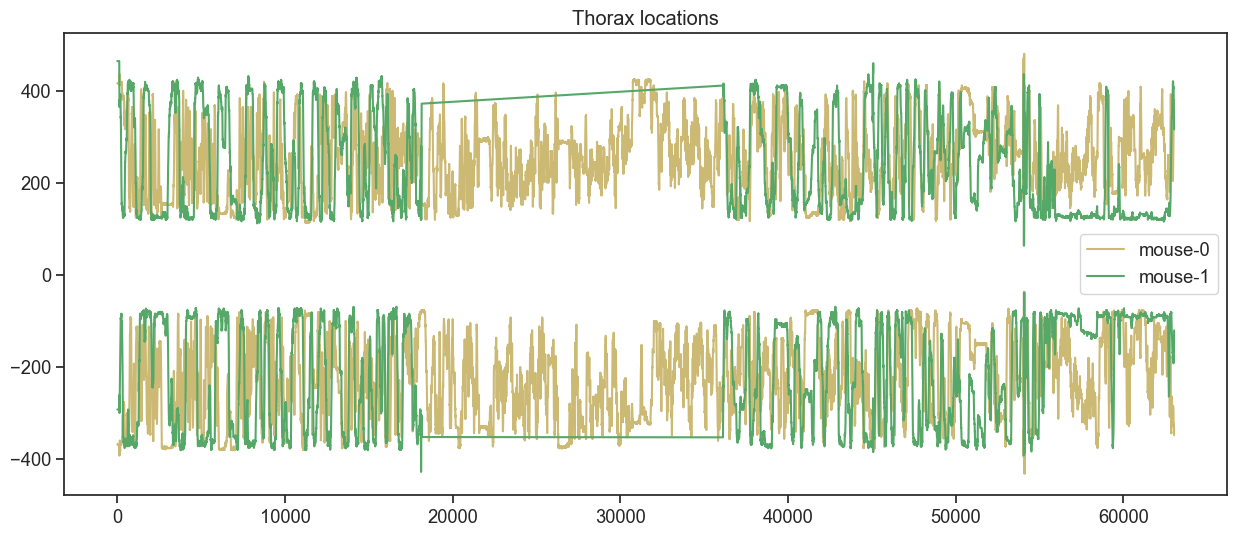

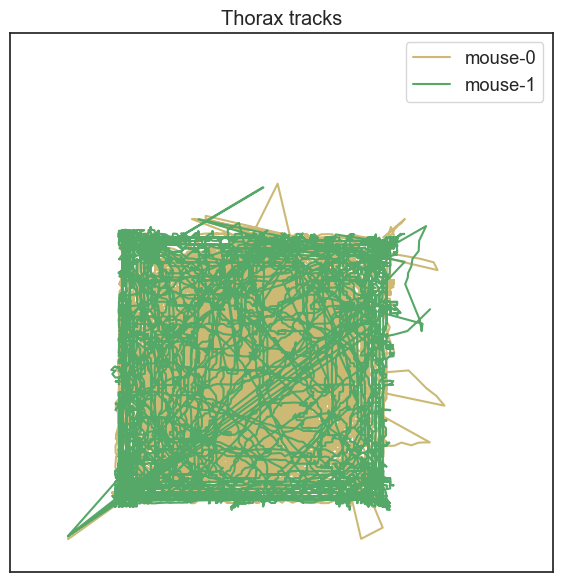

In [15]:
plt.figure()
plt.plot(thorax_loc[:,0,0], 'y',label='mouse-0')
plt.plot(thorax_loc[:,0,1], 'g',label='mouse-1')

plt.plot(-1*thorax_loc[:,1,0], 'y')
plt.plot(-1*thorax_loc[:,1,1], 'g')

plt.legend(loc="center right")
plt.title('Thorax locations')


plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0,0],thorax_loc[:,1,0], 'y',label='mouse-0')
plt.plot(thorax_loc[:,0,1],thorax_loc[:,1,1], 'g',label='mouse-1')
plt.legend()

plt.xlim(0,600)
plt.xticks([])

plt.ylim(0,600)
plt.yticks([])
plt.title('Thorax tracks')

In [31]:
type(thorax_loc)

numpy.ndarray

In [ ]:
#np.save('thorax_locations' + '.npy', thorax_loc)

In [38]:
thorax_loc.shape

(63033, 2, 2)

In [48]:
thorax_loc[:,:,0][:,0].shape

(63033,)

Comments: check what's going on between frame 19k and 38k .. the interpolation just gave a straight line that clearly isn't the expected trend..so try using a quadcratic or cubic measure?

## More Advanced Visualizations

In [17]:
# apply a Savitzky-Golay filter to smooth and differentiate the data

from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

In [50]:
# 1d version of above function
def smooth_diff_1d(node_loc, win=25, poly=3):
    """
    node_loc is a [frames,] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    node_loc_vel = savgol_filter(node_loc, win, poly, deriv=1)


    return node_loc_vel

In [51]:
# get the x and y velcoties for the two mice
thx_velx_m0 = smooth_diff_1d(thorax_loc[:,0,0])
thx_vely_m0 = smooth_diff_1d(thorax_loc[:,1,0])

thx_velx_m1 = smooth_diff_1d(thorax_loc[:,0,1])
thx_vely_m1 = smooth_diff_1d(thorax_loc[:,1,1])


In [ ]:
m0_vels = np.stack([thx_velx_m0,thx_vely_m0], axis=1)
m1_vels = np.stack([thx_velx_m1,thx_vely_m1], axis=1)

In [ ]:
velocities = np.stack([m0_vels,m1_vels], axis=1)
#np.save('velocities'+'.npy', velocities)

In [64]:
velocities.shape

(63033, 2, 2)

In [ ]:
# np.save('m0_velx'+ '.npy', thx_velx_m0)
# np.save('m0_vely'+ '.npy', thx_vely_m0)

# np.save('m1_xvel'+ '.npy', thx_velx_m1)
# np.save('m1_yvel'+ '.npy', thx_vely_m1)

In [55]:
f = np.ones(5)
g = 2*np.ones(5)
h = np.stack([f,g],axis=1)
h

array([[1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.]])

In [56]:
h.shape

(5, 2)

In [36]:
thorax_loc.shape

(63033, 2, 2)

In [39]:
# get the results for each mouse separately
thx_vel_m0 = smooth_diff(thorax_loc[:,:,0])
thx_vel_m1 = smooth_diff(thorax_loc[:,:,1])
# np.save('m0_velocity'+'.npy',thx_vel_m0)
# np.save('m1_velocity' +'.npy', thx_vel_m1)

Text(0.5, 1.0, 'Velocity')

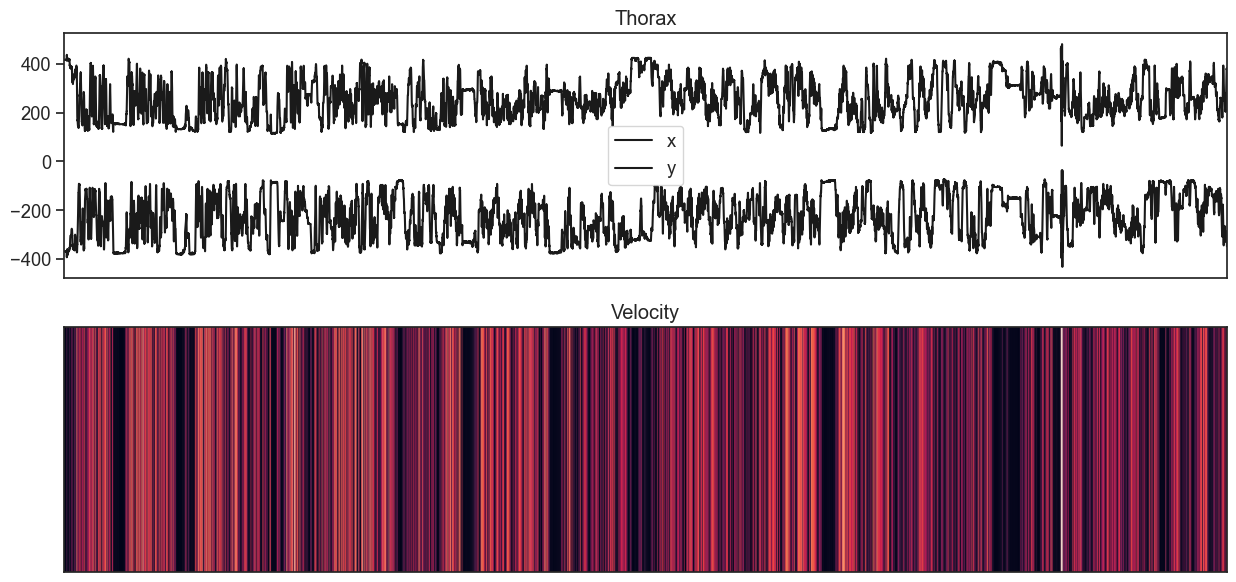

In [19]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thorax_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*thorax_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Thorax')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(thx_vel_m0[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

Comments: position of the mouse is randomly oscillating..random motion within the arena? velocity is also oscialting between its max and min values

### Visualize thorax coloured by magnitude of mouse speed

Text(0.5, 1.0, 'Thorax tracks colored by magnitude of mouse speed')

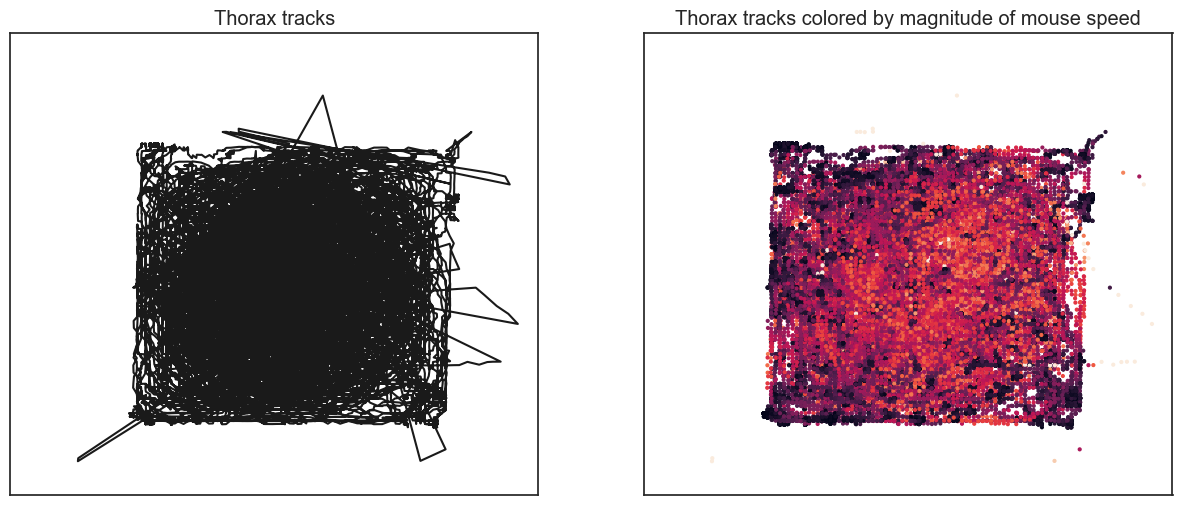

In [20]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, 0], thorax_loc[:, 1, 0], 'k')
ax1.set_xlim(0,500)
ax1.set_xticks([])
ax1.set_ylim(0,500)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

kp = thx_vel_m0  # use thx_vel_m1 for other mouse
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(thorax_loc[:,0,0], thorax_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,500)
ax2.set_xticks([])
ax2.set_ylim(0,500)
ax2.set_yticks([])
ax2.set_title('Thorax tracks colored by magnitude of mouse speed')

Comments: looks like mouse is moving slower at the edges of the arena.

## Find covariance in thorax velocities between mouse-0 and mouse-1

In [21]:
import pandas as pd

def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between
    
    win sets the number of frames over which the covariance is computed
    
    """
    
    s1 = pd.Series(datax)
    s2 = pd.Series(datay)
    
    return np.array(s2.rolling(win).corr(s1))

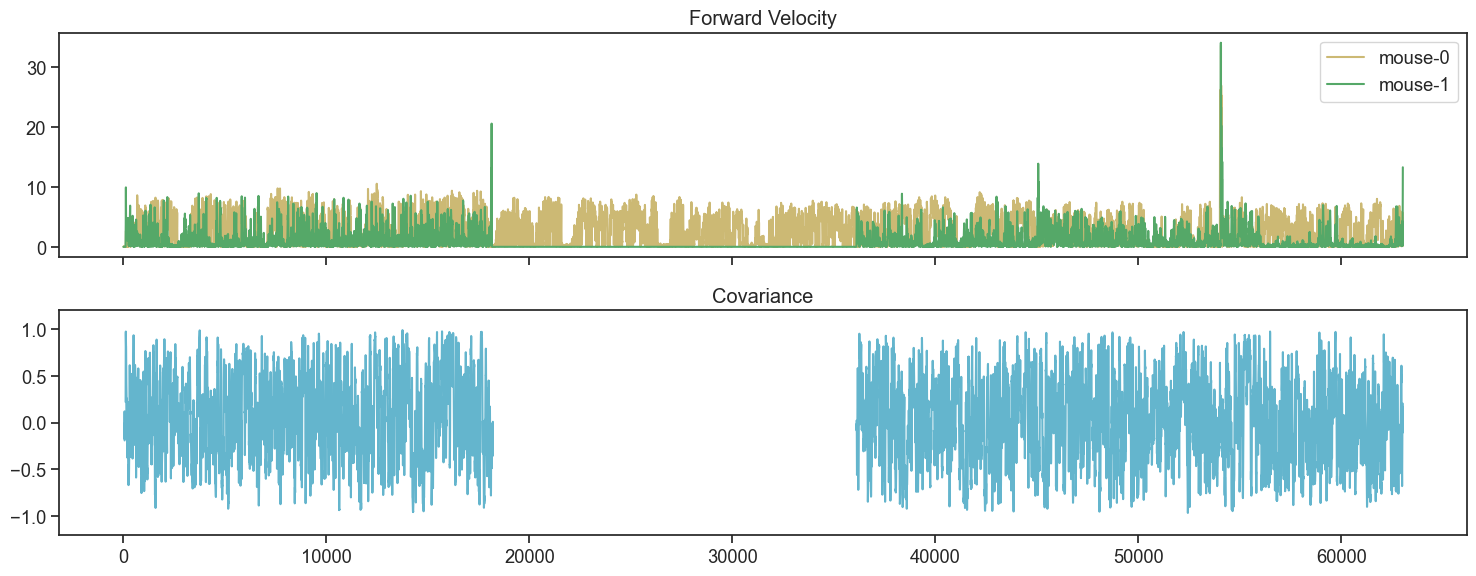

In [22]:
win = 50

cov_vel = corr_roll(thx_vel_m0, thx_vel_m1,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(thx_vel_m0, 'y', label='mouse-0')
ax[0].plot(thx_vel_m1, 'g', label='mouse-1')
ax[0].legend()
ax[0].set_title('Forward Velocity')

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()

Comments: zoom in on some window to see the covariance better

In [24]:
traindata = np.load('data/loc_train_springs5.npy')

In [25]:
traindata.shape

(2500, 49, 2, 5)

In [26]:
testdata = np.load('data/loc_test_springs5.npy')

In [27]:
testdata.shape

(1000, 99, 2, 5)